In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [3]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61406 sha256=bb7891107f1d3788ea404357b1c7185570b66743b9916bcacf4de56dde59d197
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31530 sha256=1e762ca59d6951dedde2fdefb7df5737b7782f96e7446689de38a0c11e88fd71
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu118_pyt201/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 98.5 MB/s eta 0:00:00


In [4]:
from torch.cuda import is_available

from pytorch3d.renderer.mesh.textures import TexturesAtlas
import torch

from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import(
    chamfer_distance,
    mesh_edge_loss,
    mesh_normal_consistency,
    mesh_laplacian_smoothing
)

from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    SoftPhongShader,
    MeshRenderer,
    MeshRasterizer,
    RasterizationSettings,
    TexturesAtlas,
    TexturesVertex

)

import numpy as np

from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

if torch.cuda.is_available():
  device=torch.device("cuda:0")
else:
  device=torch.device("cpu")
  print("cannot find gpu")


In [5]:
!pwd

/content


In [6]:
!ls

drive  sample_data


In [7]:
import os
os.chdir('drive/MyDrive/Colab Notebooks')

In [8]:
!ls

a1_2.ipynb  a1.ipynb  data  deform_form.ipynb  rendering_texture_obj.ipynb


In [9]:
!ls

a1_2.ipynb  a1.ipynb  data  deform_form.ipynb  rendering_texture_obj.ipynb


In [10]:
DATA_DIR='./data'

obj_file="cow_mesh/cow.obj"

obj_file=os.path.join(DATA_DIR, obj_file)


torch.Size([1, 4, 3])


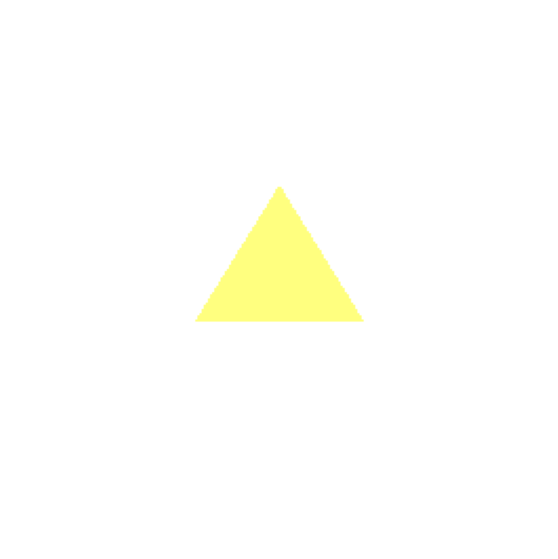

In [20]:
#rotation of the cow
import imageio
import math



verts = torch.tensor([[math.sqrt(3),0,-1],[0,0,2],[-math.sqrt(3),0,-1],[0,3,0]]).to(device)
faces = torch.tensor([[1,0,3],[3,2,1],[0,2,3],[0,1,2]]).to(device)

color=[50,100,1]
textures=torch.ones_like(verts.unsqueeze(0))
textures=textures.to(device)
textures= textures* torch.tensor(color).to(device)
print(textures.shape)


mesh=Meshes(verts=[verts], faces= [faces], textures=TexturesVertex(textures) )


#settings cameras
nums_view=24
R, T = look_at_view_transform(10,120,torch.linspace(start=0, end=180, steps=nums_view))

# cameras=FoVPerspectiveCameras(device=device, R=R, T=T)
cameras = FoVPerspectiveCameras(
    R=R, T=T, fov=60, device=device
)

#rasterization
raster_settings=RasterizationSettings(
    image_size=256,
    blur_radius=0.0,
    faces_per_pixel=1
)

lights=PointLights(device=device, location=[0,0,1])

renderer=MeshRenderer(
    MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=SoftPhongShader(
                            device=device,
                            cameras=cameras
                        )
                      )
meshes=mesh.extend(nums_view)
images=renderer(meshes)
results=[]
for i in range(nums_view):
  results.append(images[i, ... , :3].detach().cpu().numpy())

imageio.mimsave("/content/drive/MyDrive/Colab Notebooks/1.gif", results, fps=10)

# plt.figure(figsize=(7,7))

# cpu_image=images[0, ... , :3].cpu().numpy()

# plt.imshow(cpu_image)
# plt.axis("off");


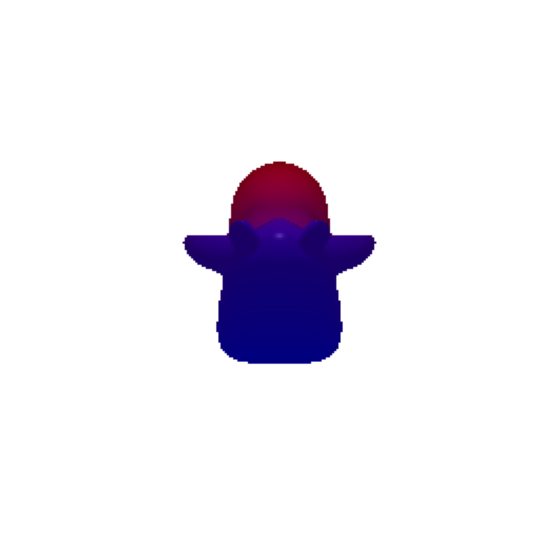

In [87]:
#rotation of the cow
import imageio
import math


DATA_DIR='./data'
obj_file='cow_mesh/cow.obj'
path=os.path.join(DATA_DIR, obj_file)

verts,face,_=load_obj(path, device=device)


# color=[50,100,1]
# textures=torch.ones_like(verts.unsqueeze(0))
# textures=textures.to(device)
# textures= textures* torch.tensor(color).to(device)
# print(textures.shape)

# print(verts.shape)
# print(face.verts_idx.shape)

len=verts.shape[0]

faces=face.verts_idx



color=[]
color1 = torch.tensor([[0, 0, 1]]).to(device)
color2 = torch.tensor([[1, 0, 0]]).to(device)

amin=torch.amin(verts[:, 2]).item()
amax=torch.amax(verts[:,2]).item()


for i in range(len):
  z=verts[i][2]



  alpha=(z-amin)/(amax-amin)

  color.append(alpha* color2+(1-alpha)*color1)

  colors=torch.stack(color, dim=0)



colors=colors.squeeze(1)
colors=colors.unsqueeze(0)
# print(colors.shape)


mesh=Meshes(verts=[verts], faces= [faces])
textures=TexturesVertex(colors.to(device))
mesh.textures=textures



#settings cameras
nums_view=24
R, T = look_at_view_transform(3,120,torch.linspace(start=0, end=180, steps=nums_view))
# R, T = look_at_view_transform(10,120,0)
# cameras=FoVPerspectiveCameras(device=device, R=R, T=T)
cameras = FoVPerspectiveCameras(
    R=R, T=T, fov=60, device=device
)

#rasterization
raster_settings=RasterizationSettings(
    image_size=256,
    blur_radius=0.0,
    faces_per_pixel=1
)

lights=PointLights(device=device, location=[0,0,1])

renderer=MeshRenderer(
    MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=SoftPhongShader(
                            device=device,
                            cameras=cameras
                        )
                      )

meshes=mesh.extend(nums_view)
images=renderer(meshes)
results=[]
for i in range(nums_view):
  results.append(images[i, ... , :3].detach().cpu().numpy())

imageio.mimsave("/content/drive/MyDrive/Colab Notebooks/3_b.gif", results, fps=10)

plt.figure(figsize=(7,7))

cpu_image=images[0, ... , :3].cpu().numpy()

plt.imshow(cpu_image)
plt.axis("off");